In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
#from sklearn.metrics import jaccard_similarity_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

from pathlib import Path

## Get paths for images and sort them

In [2]:

path = 'data/DRIVE/'
path_test = 'test/images'
path_test_mask = 'test/1st_manual'
path_train = 'training/images_gray'
path_train_mask = 'training/manual'

img_path = Path(os.path.join(path, path_train))
mask_path = Path(os.path.join(path, path_train_mask))
test_img_path = Path(os.path.join(path, path_test))
test_mask_path = Path(os.path.join(path, path_test_mask))

#sort images to line up train and mask
img_names = []
mask_names = []
test_img_names = []
test_mask_names = []
for img, mas, test_img, test_mask in zip(img_path.iterdir(), mask_path.iterdir(),
                                         test_img_path.iterdir(),
                                         test_mask_path.iterdir()):
    img_names.append(str(img))
    mask_names.append(str(mas))
    test_img_names.append(str(test_img))
    test_mask_names.append(str(test_mask))
    
mask_names.sort()
img_names.sort()
test_img_names.sort()
test_mask_names.sort()

In [3]:
len(test_img_names)

20

(584, 565)
(584, 565)


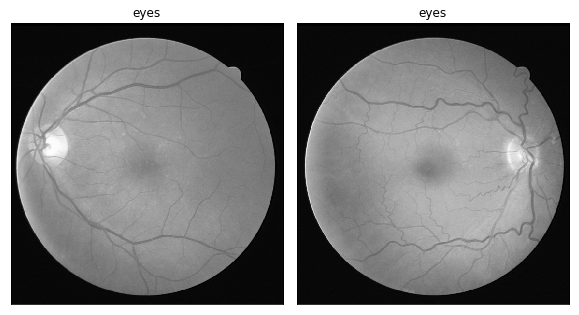

(584, 565)
(584, 565)


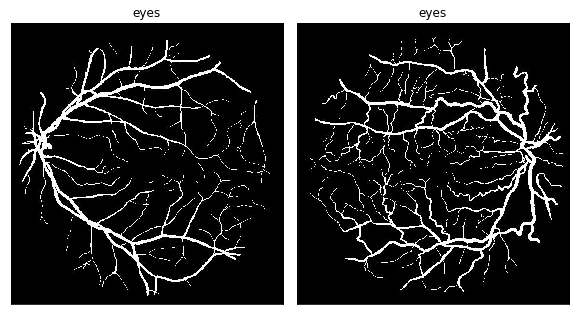

In [4]:
##show first two images 
def showImg(p):
    fig, axes = plt.subplots(1, 2, figsize=(10,10),
                         subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax, i in zip(axes.flat, range(2)):
        img = imread(p[i])
        ax.imshow(img, cmap='gray')
        ax.set_title('eyes')  
        print(img.shape)
    plt.show()
    
showImg(img_names)
showImg(mask_names)


### Resize and flip images

In [5]:
im_width = 560
im_height = 560
im_chan = 3
X_train = np.zeros((len(img_names)*3, im_height, im_width, 1), dtype=np.uint8)
Y_train = np.zeros((len(img_names)*3, im_height, im_width, 1), dtype=np.bool_)
X_test = np.zeros((len(img_names), im_height, im_width, 1), dtype=np.uint8)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

counter = 0
for i in tqdm_notebook(range(len(img_names))):
    img = imread(img_names[i])
    x = resize(img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    X_train[counter] = x
     
    mask = imread(mask_names[i])
    m_ = np.zeros_like(mask)
    for k in range(584):
        for j in range(564):
            if mask[k][j]>50 :
                m_[k][j] = 1
    
    mask = resize(m_, (im_height, im_width, 1), mode='constant', preserve_range=True) 
    Y_train[counter] = mask    
    counter += 1
    
    #mod image and mask together
    X_train[counter] = np.fliplr(x)
    Y_train[counter] = np.fliplr(mask)
    
    counter +=1
    
    X_train[counter] = np.flipud(x)
    Y_train[counter] = np.flipud(mask)    
    counter +=1
    
    #resize for test images
    test_img = imread(test_img_names[i])
    test_img = resize(test_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    X_test[i] = test_img
   
print('Done!')

Getting and resizing train images and masks ... 


/home/tony/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/tony/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)



Done!


In [6]:
X_train[0].shape

(560, 560, 1)

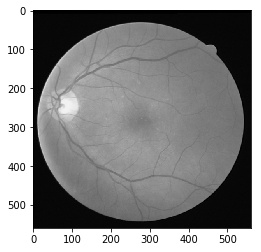

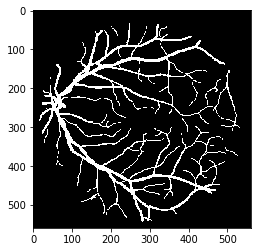

In [7]:
#resized images
ix = 0
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

### Create dataset

In [8]:
class eye_dataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images, train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
            return (image, mask)
        return image

In [9]:
X_train[0].shape

(560, 560, 1)

In [10]:
#reshape
X_train_shaped = X_train.reshape(-1, 1, 560, 560)/255
Y_train_shaped = Y_train.reshape(-1, 1, 560, 560)

X_test_shaped = X_test.reshape(-1,1, 560, 560)/255

In [11]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

X_test_shaped = X_test_shaped.astype(np.float32)

In [12]:
X_train_shaped[0].shape

(1, 560, 560)

In [13]:
X_test_shaped[0].shape

(1, 560, 560)

In [14]:
#split
idx = list(range(60))
train_idxs = idx[:48]
val_idxs = idx[48:]

In [15]:
val_idxs

[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

In [16]:
eye_dataset_train = eye_dataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])
eye_dataset_val = eye_dataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

eye_test_dataset = eye_dataset(X_test_shaped[:10], train=False)

batch_size = 8

train_loader = torch.utils.data.DataLoader(dataset=eye_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=eye_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=eye_test_dataset, batch_size=batch_size,
                                         shuffle=False)

In [17]:
def conv_layer(chanIn, chanOut, ks = 3, stride=1):
    return nn.Sequential(
        nn.Conv2d(chanIn, chanOut, ks, stride, padding=ks//2),
        nn.ReLU(),
        nn.BatchNorm2d(chanOut)
        )

class Conv_block(nn.Module):
    def __init__(self, chanIn, chanOut, pool = False):
        super().__init__()
        
        self.conv1 = conv_layer(chanIn, chanOut)
        self.conv2 = conv_layer(chanOut, chanOut)
        
    def forward(self, x) : 
        x = self.conv1(x)
        x = self.conv2(x)
        return x
        
class Mid_block(nn.Module):
    def __init__(self, chanIn, chanOut, ks=3, stride=1):
        super().__init__()        
        self.conv1 = nn.Conv2d(chanIn, chanOut, ks, padding=ks//2)
        self.conv2 = nn.Conv2d(chanOut, chanOut, ks, padding=ks//2)
        
    def forward(self, x) : 
        x = self.conv1(x)
        x = self.conv2(x)
        return x
  

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
        self.down1 = Conv_block(1,16)
        self.down2 = Conv_block(16, 32)
        self.down3 = Conv_block(32,64)
        self.down4 = Conv_block(64,128)
        
        self.mid = Mid_block(128,256)
        
        self.upt3 = nn.ConvTranspose2d(256,128,2,2)
        self.up3 =Conv_block(256,128)
        self.upt2 = nn.ConvTranspose2d(128, 64,2,2)
        self.up2 = Conv_block(128,64)
        self.upt1 = nn.ConvTranspose2d(64, 32,2,2)
        self.up1 = Conv_block(64,32)
        self.upt0 = nn.ConvTranspose2d(32, 16,2,2)
        self.up0 = Conv_block(32,16)
        self.last = nn.Conv2d(16,1,1)
        
        self.maxPool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(p=.25, inplace=True)
        
    
    def forward(self, x):
        x1 = self.down1(x)
        p1 = self.maxPool(x1)
        p1 = self.dropout(p1)
        
        x2 = self.down2(p1)
        p2 = self.maxPool(x2)
        p2 = self.dropout(p2)
        
        x3 = self.down3(p2)
        p3 = self.maxPool(x3)
        p3 = self.dropout(p3)
        
        x4 = self.down4(p3)
        p4 = self.maxPool(x4)
        p4 = self.dropout(p4)
        
        xmid = self.mid(p4)
        
        xu3 = self.upt3(xmid)
        cat3 = torch.cat([x4, xu3],1)
        xu3 = self.up3(cat3)
        
        xu2 = self.upt2(xu3)
        cat2 = torch.cat([x3, xu2],1)
        xu2 = self.up2(cat2)
                
        xu1 = self.upt1(xu2)
        cat1 = torch.cat([x2,xu1],1)
        xu1 = self.up1(cat1)
        
        xu0 = self.upt0(xu1)
        cat0 = torch.cat([x1,xu0],1)
        xu0 = self.up0(cat0)
        return self.last(xu0)

In [18]:
model = Unet()
model.cuda();

criterion = nn.BCEWithLogitsLoss()

learning_rate = 0.01 #1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', 
                                                       factor=0.1, 
                                                       patience=9,
                                                       threshold=.000001, 
                                                       verbose=True)


In [19]:
mean_train_losses = []
mean_val_losses = []
for epoch in range(200):
    train_losses = []
    val_losses = []
    for images, masks in train_loader:        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)        
        
        loss = criterion(outputs, masks)
        train_losses.append(loss.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    for images, masks in val_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_losses.append(loss.data)
    
    
    mean_train_losses.append(np.mean(train_losses))
    mean_val_losses.append(np.mean(val_losses))
    scheduler.step(mean_val_losses[epoch])
    
    # Print Loss
    print('Epoch: {}. Train Loss: {}. Val Loss: {}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses)))


Epoch: 1. Train Loss: 0.6596388816833496. Val Loss: 0.6051117181777954
Epoch: 2. Train Loss: 0.5742883682250977. Val Loss: 0.510536253452301
Epoch: 3. Train Loss: 0.4681285619735718. Val Loss: 0.38747847080230713
Epoch: 4. Train Loss: 0.35256120562553406. Val Loss: 0.2887088358402252
Epoch: 5. Train Loss: 0.26810190081596375. Val Loss: 0.20845752954483032
Epoch: 6. Train Loss: 0.2124605029821396. Val Loss: 0.16910210251808167
Epoch: 7. Train Loss: 0.18609519302845. Val Loss: 0.15011513233184814
Epoch: 8. Train Loss: 0.17232465744018555. Val Loss: 0.14534306526184082
Epoch: 9. Train Loss: 0.16445009410381317. Val Loss: 0.14007854461669922
Epoch: 10. Train Loss: 0.16620123386383057. Val Loss: 0.13984200358390808
Epoch: 11. Train Loss: 0.16084790229797363. Val Loss: 0.13631659746170044
Epoch: 12. Train Loss: 0.1575556993484497. Val Loss: 0.13170793652534485
Epoch: 13. Train Loss: 0.1565181165933609. Val Loss: 0.13212507963180542
Epoch: 14. Train Loss: 0.15892580151557922. Val Loss: 0.1328

Epoch: 113. Train Loss: 0.10650409013032913. Val Loss: 0.0953914076089859
Epoch: 114. Train Loss: 0.1042453944683075. Val Loss: 0.09443892538547516
Epoch: 115. Train Loss: 0.10399675369262695. Val Loss: 0.09464745223522186
Epoch: 116. Train Loss: 0.10425049066543579. Val Loss: 0.0951443612575531
Epoch: 117. Train Loss: 0.10456348210573196. Val Loss: 0.094881571829319
Epoch: 118. Train Loss: 0.10363718122243881. Val Loss: 0.09465279430150986
Epoch: 119. Train Loss: 0.10292982310056686. Val Loss: 0.09668867290019989
Epoch: 120. Train Loss: 0.10294824838638306. Val Loss: 0.09558882564306259
Epoch: 121. Train Loss: 0.10342445969581604. Val Loss: 0.09546326100826263
Epoch: 122. Train Loss: 0.10466506332159042. Val Loss: 0.09368179738521576
Epoch: 123. Train Loss: 0.10290148109197617. Val Loss: 0.09711074084043503
Epoch: 124. Train Loss: 0.10321098566055298. Val Loss: 0.09662207961082458
Epoch: 125. Train Loss: 0.10229378193616867. Val Loss: 0.09332981705665588
Epoch: 126. Train Loss: 0.1033

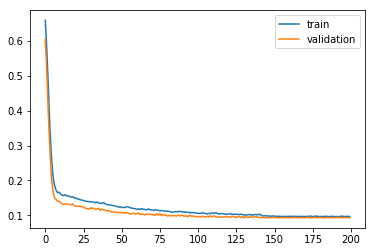

In [20]:
train_loss_series = pd.Series(mean_train_losses)
val_loss_series = pd.Series(mean_val_losses)
train_loss_series.plot(label="train")
val_loss_series.plot(label="validation")
plt.legend()

In [21]:
res = []
for im in test_loader:
    image = Variable(im.type(torch.FloatTensor).cuda())
    y_pred = model(image)
    res.append(y_pred)

In [22]:
res[0][0].shape

torch.Size([1, 560, 560])

In [23]:
result =res[0][0].reshape(560, 560,-1)

In [24]:
result.shape

torch.Size([560, 560, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


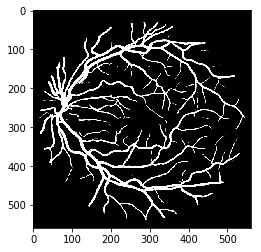

In [25]:
res1 = result.data.cpu().numpy()
res1 = np.squeeze(res1).astype(np.float32)
plt.imshow(np.dstack((res1,res1,res1)))

In [26]:
def showRes(p):
    fig, axes = plt.subplots(1, 2, figsize=(20,10),
                         subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax, i in zip(axes.flat, range(2)):
       # p = p.data.cpu().numpy()
       # p = np.squeeze(p).astype(np.float32)
        ax.imshow(np.dstack((p,p,p)))
        ax.set_title('Result')  
        
    plt.show()

/home/tony/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


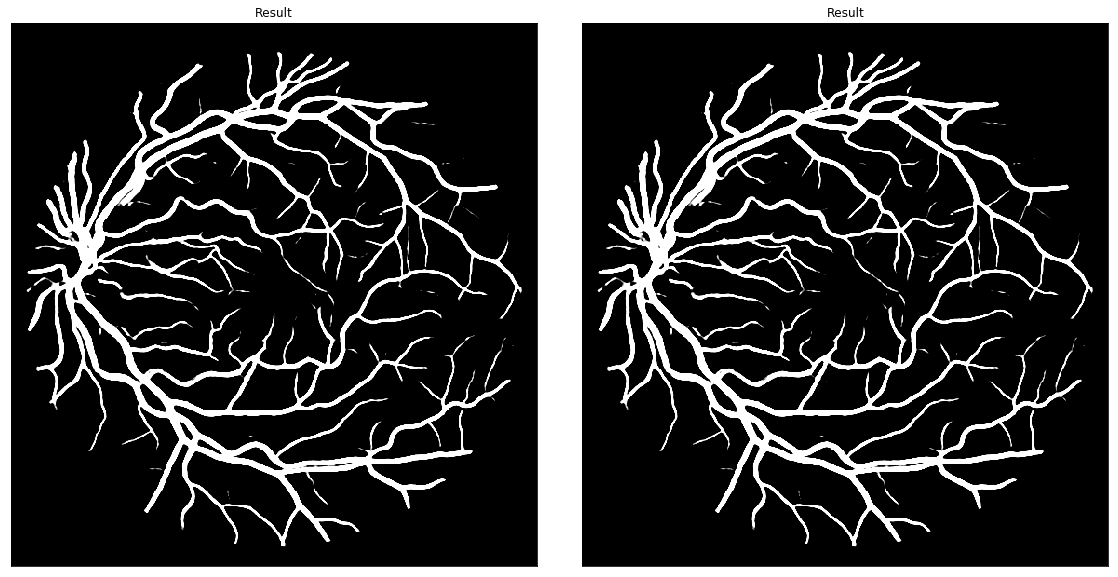

In [27]:
x = resize(res1, (584, 565, 1), mode='constant', preserve_range=True)
showRes(x)

/home/tony/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


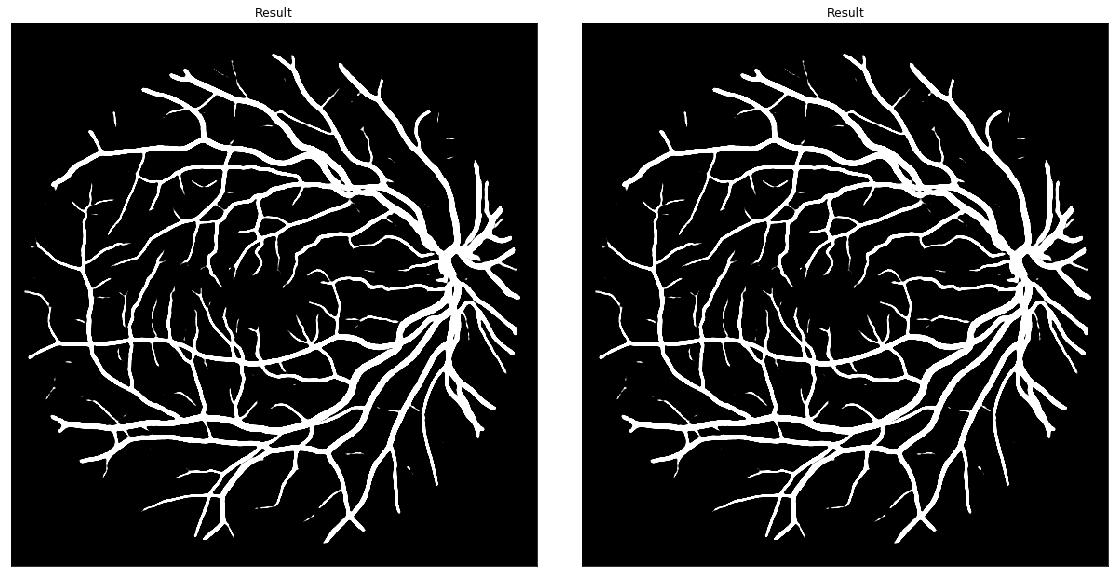

In [28]:
result =res[0][1].reshape(560, 560,-1)
res1 = result.data.cpu().numpy()
res1 = np.squeeze(res1).astype(np.float32)
x = resize(res1, (584, 565, 1), mode='constant', preserve_range=True)
showRes(x)

In [30]:
torch.save(model.state_dict(), 'data/eyeResults/res_sep11.pth' )

In [31]:
# the_model = Unet()
# the_model.load_state_dict(torch.load('data/eyeResults/res_sep11.pth'))

In [34]:
# for im in test_loader:
#     image = Variable(im.type(torch.FloatTensor).cuda())
#     image = image.unsqueeze(0)
#     y_pred = the_model(image)
#     res.append(y_pred)